/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipyke

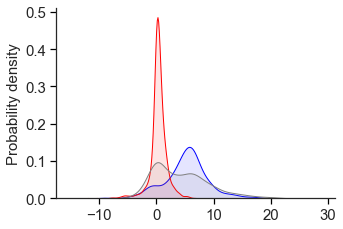

In [15]:
#******************************************************************
#  Plot mean annual time series for historical periods
#  Author: Yanyan Cheng, 04/23/2019
#******************************************************************
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from netCDF4 import Dataset
from scipy import stats
from matplotlib import rc, rcParams
import os

import seaborn as sns
plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5)

title_size  = 17
marker_size = 7
stepsize    = 0.01
label_size  = 15
border_size = 1.0
tick_size   = 15
legend_size = 10
line_width  = 0.5
rotation    = 45
text_size   = 10
unit_size   = 11
box_width   = 0.22
box_linewidth=1
max_min_markersize=3
markersize=50
alpha=1.0

### read netcdf data
def read_data(fname,var):
    pt=Dataset(fname, 'r')
    data=pt.variables[var][:]
    return data

def mask_high_low_forest(firstyr_forest,forestdiff,data,sign):
    if (sign =="sigreforestation"):
        diff_threshold= 25
    elif (sign == "highforestation"):
        diff_threshold = 5
        forest_threshold = 90.0
    elif (sign == "lowforestation"):
        diff_threshold = 5
        forest_threshold = 10.0
                
    if (sign =="sigreforestation"):
        data=np.where(forestdiff<=diff_threshold, np.nan,data)
    elif (sign == "highforestation"):
        data=np.where(firstyr_forest<=forest_threshold, np.nan,data)
        data=np.where(forestdiff>=diff_threshold, np.nan,data)
        data=np.where(forestdiff<=0.0, np.nan,data)
    elif (sign == "lowforestation"):
        data=np.where(firstyr_forest>=forest_threshold, np.nan,data)
        data=np.where(firstyr_forest<=0.0, np.nan,data)
        data=np.where(forestdiff>=diff_threshold, np.nan,data)
        data=np.where(forestdiff<=0.0, np.nan,data)
    return data

def fillmissing(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data

def subplot_pair(paras1,paras2,paras3):
    figure_rows, figure_cols = 1,1
    fig, axs = plt.subplots(figure_rows, figure_cols, figsize=(figure_width,figure_length))
    sns.despine(left=False,bottom=False)
    
    plt.rcParams["axes.labelsize"] = label_size
    plt.rcParams["axes.titlesize"] = label_size
    plt.rcParams["xtick.labelsize"] = label_size
    plt.rcParams["ytick.labelsize"] = label_size
    plt.rcParams["legend.fontsize"]=label_size

    rc('font', style='normal')
    rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \italicmath']
    
    ax=axs
    ylabel = "Probability density"
    alpha=0.1
    orange="#F4AA00"
    green="#2C43FA"
    plot_hist = False
    color1="blue"
    color2="red"
    color3="grey"
    xlabel=r"$\Delta$"+"Vegetation C (kg C/m$^2$)\n(2100 vs. 2015)"
    sns.distplot(paras1, hist=plot_hist, color=color1,axlabel=xlabel, \
                 kde_kws={"shade": True,"alpha": alpha},ax=ax)
    sns.distplot(paras2, hist=plot_hist, color=color2,axlabel=xlabel, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    sns.distplot(paras3, hist=plot_hist, color=color3,axlabel=xlabel, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    
    ax.tick_params(axis='both', which='major', labelsize=tick_size,color="k")
    ax.set_xlabel("",fontsize=label_size,fontstyle="normal")
    ax.set_ylabel(ylabel,fontsize=label_size,fontstyle="normal")
    
    fig.patch.set_facecolor("white")
    fig.patch.set_alpha(0.0)
    
    fig_dir = "../figures/"
    bname = "Fig3b"
    figname=fig_dir+bname+'.pdf'
    os.system("rm -f "+figname)
    plt.savefig(figname,bbox_inches='tight')

def read_one_ensemble(caseid):
    fname=data_dir +var+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100.nc"
    vegc = read_data(fname, "value")
    missVal=1e36
    vegc=fillmissing(vegc,missVal)
    vegc = vegc / 1000. #convert gC/m2 to kgC/m2
    diff=vegc[-1,:,:] - vegc[0,:,:]
    return diff
    
def subplot(sign,crop):
    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble(caseid)

    diff = np.nanmean(ensbase,axis=0)
    diff = diff.reshape(nlat*nlon)
    
    ### read forest fraction
    if (sign == "sigreforestation"):
        lastyr = "2060"

    else:
        lastyr = "2100"
            
    fname=data_dir+crop+"_frac_2015_SSP126Lu-REFOREST.nc"
    firstyr_forest = read_data(fname, "biofrac") * 100.
    fname=data_dir+crop+"_frac_"+lastyr+"_SSP126Lu-REFOREST.nc"
    lastyr_forest = read_data(fname, "biofrac") * 100.
    
    forestdiff=lastyr_forest-firstyr_forest
    forestdiff = forestdiff.reshape(nlat*nlon)
    
    lastyr_forest=lastyr_forest.reshape(nlat*nlon)
    firstyr_forest=firstyr_forest.reshape(nlat*nlon)
        
    vegc_forplot = mask_high_low_forest(firstyr_forest,forestdiff,diff,sign)

    return vegc_forplot

################
## plot figure, time series
################
figure_width=7
figure_length=5
figure_width=5
figure_length=3.5
figure_rows = 1
figure_cols = 1

ens_size=3
data_dir="../data/"

color1="#ca0020"
color2="#0571b0"

linestyle1,linestyle2="-","-"

years=np.arange(2015,2100,5)
indexs=np.arange(len(years))
yeari_dic={ivar: ivar_array for (ivar, ivar_array) in zip(years,indexs)}

nlat,nlon = 192,288

signs = ["highforestation","lowforestation","sigreforestation"]
titles = ["High and constant $frac$$_{forest}$","Low and constant $frac$$_{forest}$",\
         "Significant reforesation"]
title_dic={ivar: ivar_array for (ivar, ivar_array) in zip(signs,titles)}
barposition="horizontal"

var = "TOTECOSYSC"

crop="forest"
sign = signs[0]
paras1=subplot(sign,crop)

sign = signs[1]
paras2=subplot(sign,crop)

sign = signs[2]
paras3=subplot(sign,crop)

subplot_pair(paras1,paras2,paras3)